# Speech Understanding 
# Lecture 6: do-it-yourself speech recognition



### Mark Hasegawa-Johnson, KCGI, November 18, 2022

In today's lecture, we will learn how to create the mel-frequency spectrogram of a vowel.  The mel-frequency spectrogram is a feature that can be used for automatic speech recognition.

Here are the contents:
1. <a href="#section_recording">Record 3 vowels X 2 copies each = 6 audio files</a>
1. <a href="#section_spectrogram">Calculate the mel-frequency spectrogram</a>
1. <a href="#section_melspectrum">Calculate the average mel-frequency spectrum</a>
1. <a href="#section_recognition">Recognize a vowel by finding its nearest neighbor</a>
1. <a href="#homework">Homework</a>

<a id='section_recording'></a>

## 1.  Recording 3 vowels X 2 copies each = 6 audio files

Use either [ipywebrtc](https://ipywebrtc.readthedocs.io/en/latest/) or [Praat](https://praat.org) to record 3 vowels X 2 copies each = 6 audio files.  This section will use ipywebrtc, but if that doesn't work for you, try Praat.

To start with, record all six vowels: "a, i, u, a, i, u"

In [18]:
from ipywebrtc import AudioRecorder, CameraStream
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

[matroska,webm @ 0x13f605720] EBML header parsing failed
recording.webm: Invalid data found when processing input


Text(0.5, 1.0, 'Recording of 3 vowels X 2 recordings each')

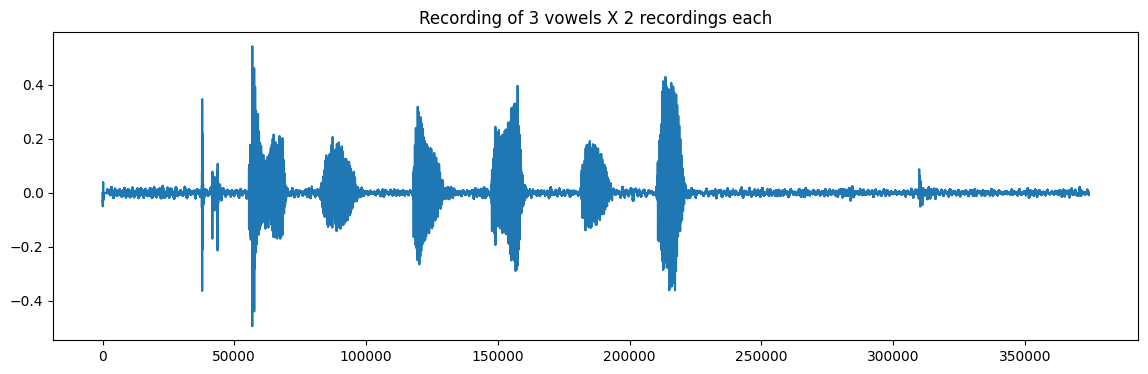

In [19]:
with open('recording.webm','wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -y -loglevel error -i recording.webm -ac 1 recording.wav
import soundfile as sf
speech_wave, speech_rate = sf.read("recording.wav")
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,4))
ax = fig.subplots()
ax.plot(speech_wave)
plt.title('Recording of 3 vowels X 2 recordings each')

Now try reading off the starting sample and ending sample of each of the six vowels.  Don't worry if you don't get it exactly right, as long as you mostly are able to separate the vowels.

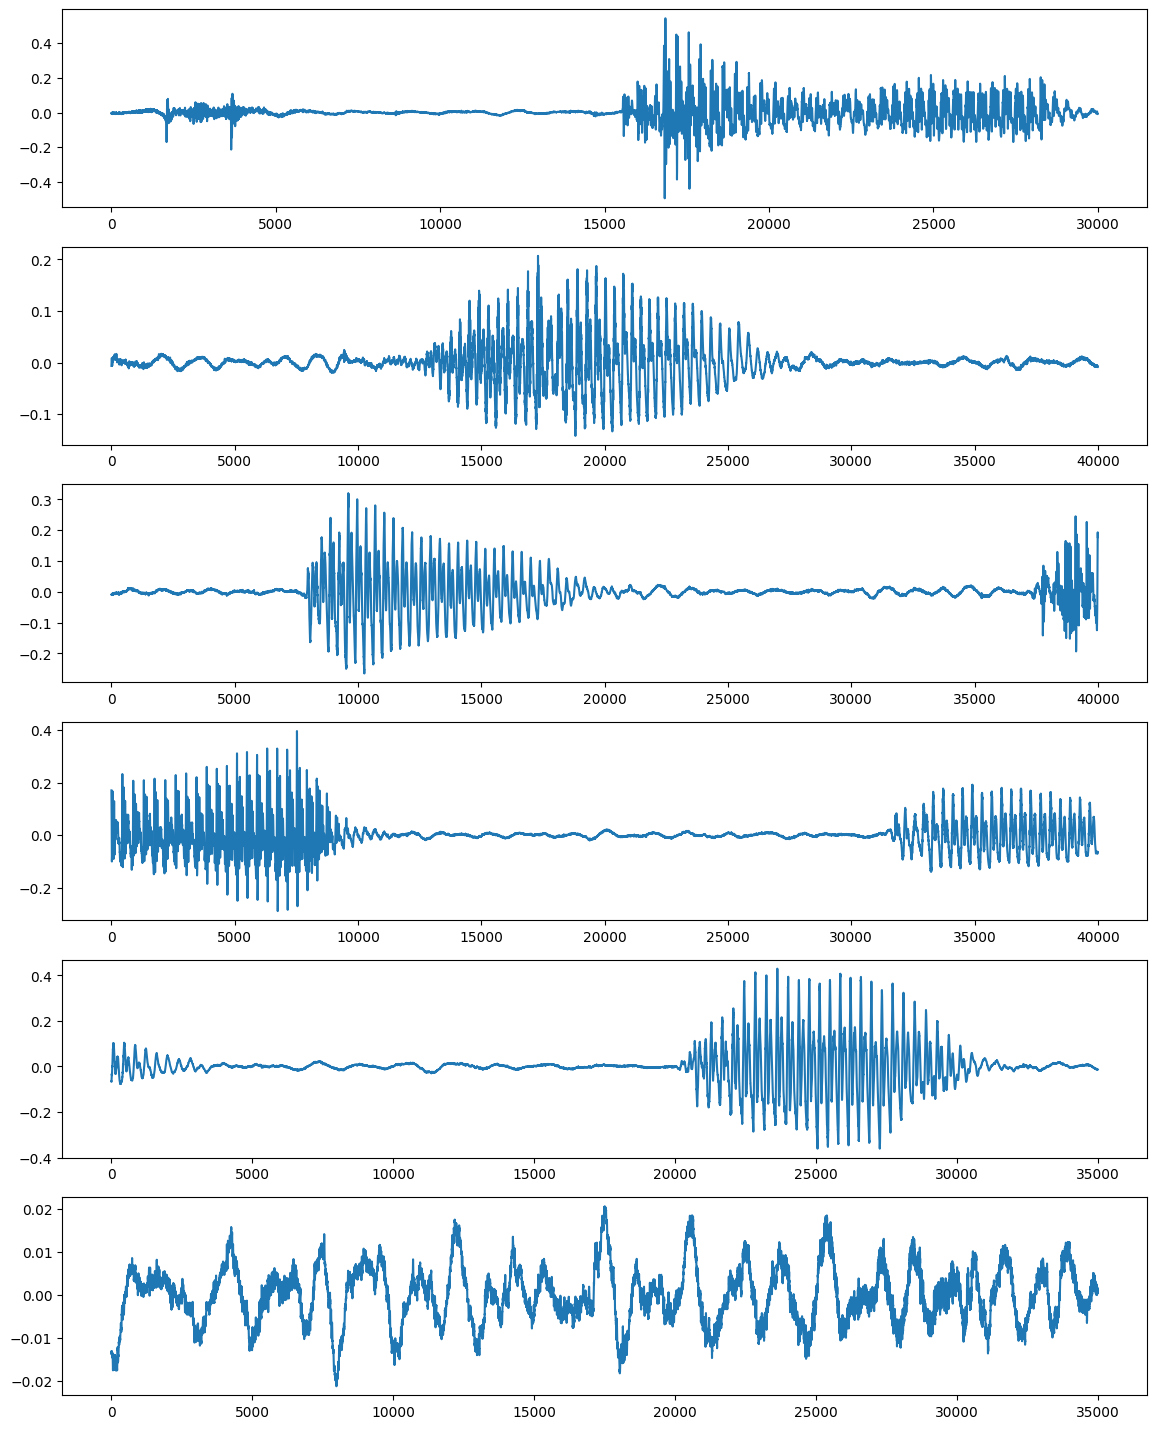

In [20]:
starting_sample = [40000, 70000, 110000, 150000, 190000, 225000]
ending_sample = [70000, 110000, 150000, 190000, 225000, 260000]
fig=plt.figure(figsize=(14,18))
axes = fig.subplots(6,1)
for n in range(6):
    axes[n].plot(speech_wave[starting_sample[n]:ending_sample[n]])

If the plots above look OK, then try to split the recording into separate waveforms, and listen to the result.

In [21]:
aa1 = speech_wave[starting_sample[0]:ending_sample[0]]
ii1 = speech_wave[starting_sample[1]:ending_sample[1]]
uu1 = speech_wave[starting_sample[2]:ending_sample[2]]
aa2 = speech_wave[starting_sample[3]:ending_sample[3]]
ii2 = speech_wave[starting_sample[4]:ending_sample[4]]
uu2 = speech_wave[starting_sample[5]:ending_sample[5]]

import IPython
IPython.display.Audio(data=ii2, rate=speech_rate)

The following is optional: I recommend that you now save all of the separate waveform files, so that you can re-load them any time you want to.

In [22]:
import soundfile as sf
sf.write("aa1.wav",aa1,speech_rate)
sf.write("aa2.wav",aa2,speech_rate)
sf.write("ii1.wav",ii1,speech_rate)
sf.write("ii2.wav",ii2,speech_rate)
sf.write("uu1.wav",uu1,speech_rate)
sf.write("uu2.wav",uu2,speech_rate)

<a id='section_spectrogram'></a>

## 2. Calculate the Mel spectrogram using [librosa](https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html)

First: in case you took a break between parts 1 and 2, you might want to re-load the waveforms, as shown below.

In [23]:
import soundfile as sf
aa1, speech_rate = sf.read("aa1.wav")
aa2, speech_rate = sf.read("aa2.wav")
ii1, speech_rate = sf.read("ii1.wav")
ii2, speech_rate = sf.read("ii2.wav")
uu1, speech_rate = sf.read("uu1.wav")
uu2, speech_rate = sf.read("uu2.wav")

In lecture 1, we learned how to create **spectrograms** using Praat.  A spectrogram is an image in which 
* the X-axis shows time (in seconds),
* the Y-axis shows frequency (in Hertz), and
* the color (darkness or brightness) shows the logarithm of energy.


To calculate and display spectrograms in python, we will download the [librosa](https://librosa.org/doc/latest/index.html) module.  Go to a terminal, and type:

```
pip install librosa
```

Then the procedure for creating a spectrogram is:
* Call `librosa.stft` to calculate the complex-valued STFT (CSTFT),
* Call `np.abs` to convert the STFT into the magnitude STFT (MSTFT),
* Call `np.log` to convert the MSTFT into the Spectrogram (SGRAM).

Then you can
* Call `librosa.display.specshow` to show the spectrogram image.

Text(0.5, 1.0, 'aa1')

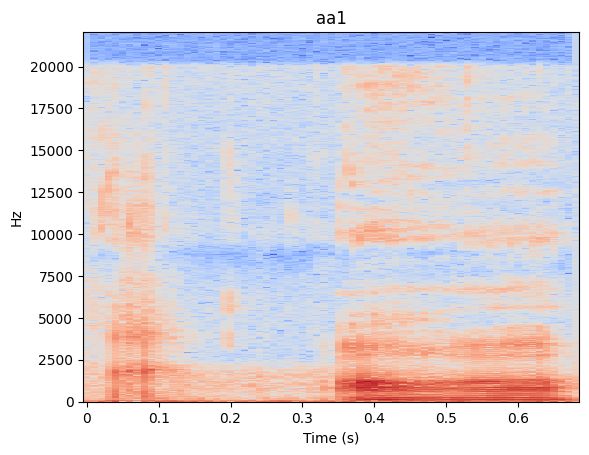

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import librosa, librosa.display

hop = int(0.010*speech_rate)
win = int(0.025*speech_rate)

aa1cstft = librosa.stft(aa1,hop_length=hop,win_length=win)
aa1mstft = np.abs(aa1cstft)
aa1sgram = np.log(aa1mstft)
librosa.display.specshow(aa1sgram,
                         sr=speech_rate,
                         hop_length=hop,
                         y_axis='hz',
                         x_axis='s'
                        )
plt.title('aa1')



Today we will create **mel-spectrograms**.  A mel-spectrogram is almost like a spectrogram:
* the X-axis shows time (in seconds),
* the Y-axis shows frequency (in **mels**), and
* the color (darkness or brightness) shows the logarithm of energy.

The [mel-scale](https://en.wikipedia.org/wiki/Mel_scale) measures the perceived distance between frequencies, instead of the physical distance.  This makes mel-spectrograms useful for measuring the distance between two speech sounds.

To calculate the melspectrogram, you need two steps:
* Call the function `librosa.feature.melspectrogram` to calculate the magnitude melgram (MMGRAM), then
* Call the function `np.log` to calculate the melspectrogram (MELGRAM).

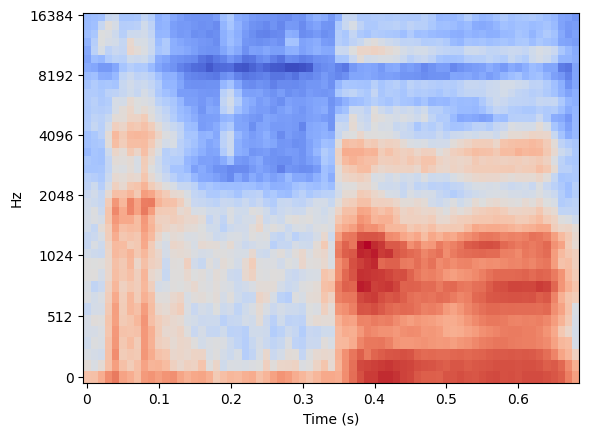

In [25]:
import librosa.feature
aa1mmgram = librosa.feature.melspectrogram(y=aa1,
                                                  sr=speech_rate,
                                                  hop_length=hop,
                                                  win_length=win,
                                                  n_mels=40,
                                                  fmax=16000)
aa1melgram = np.log(aa1mmgram)
librosa.display.specshow(aa1melgram,
                         sr=speech_rate,
                         hop_length=hop,
                         y_axis='mel',
                         x_axis='s',
                         fmax=16000
                        )

Notice that the **melspectrogram** has less information than the **spectrogram**!  It focuses on only the low frequencies, which are the ones most important for speech recognition.

In order to see that the melspectrogram keeps the information that's most important for speech recognition, let's plot the melspectrograms of all six waveforms.

In [26]:
waveforms = [[aa1,aa2],[ii1,ii2],[uu1,uu2]]
melgrams = [[None,None],[None,None],[None,None]]
for row in [0,1,2]:
    for column in [0,1]:
        mmgram = librosa.feature.melspectrogram(
            y=waveforms[row][column],
            sr=speech_rate,
            hop_length=hop,
            win_length=win,
            n_mels=40,
            fmax=16000
        )
        melgrams[row][column] = np.log(mmgram)
        

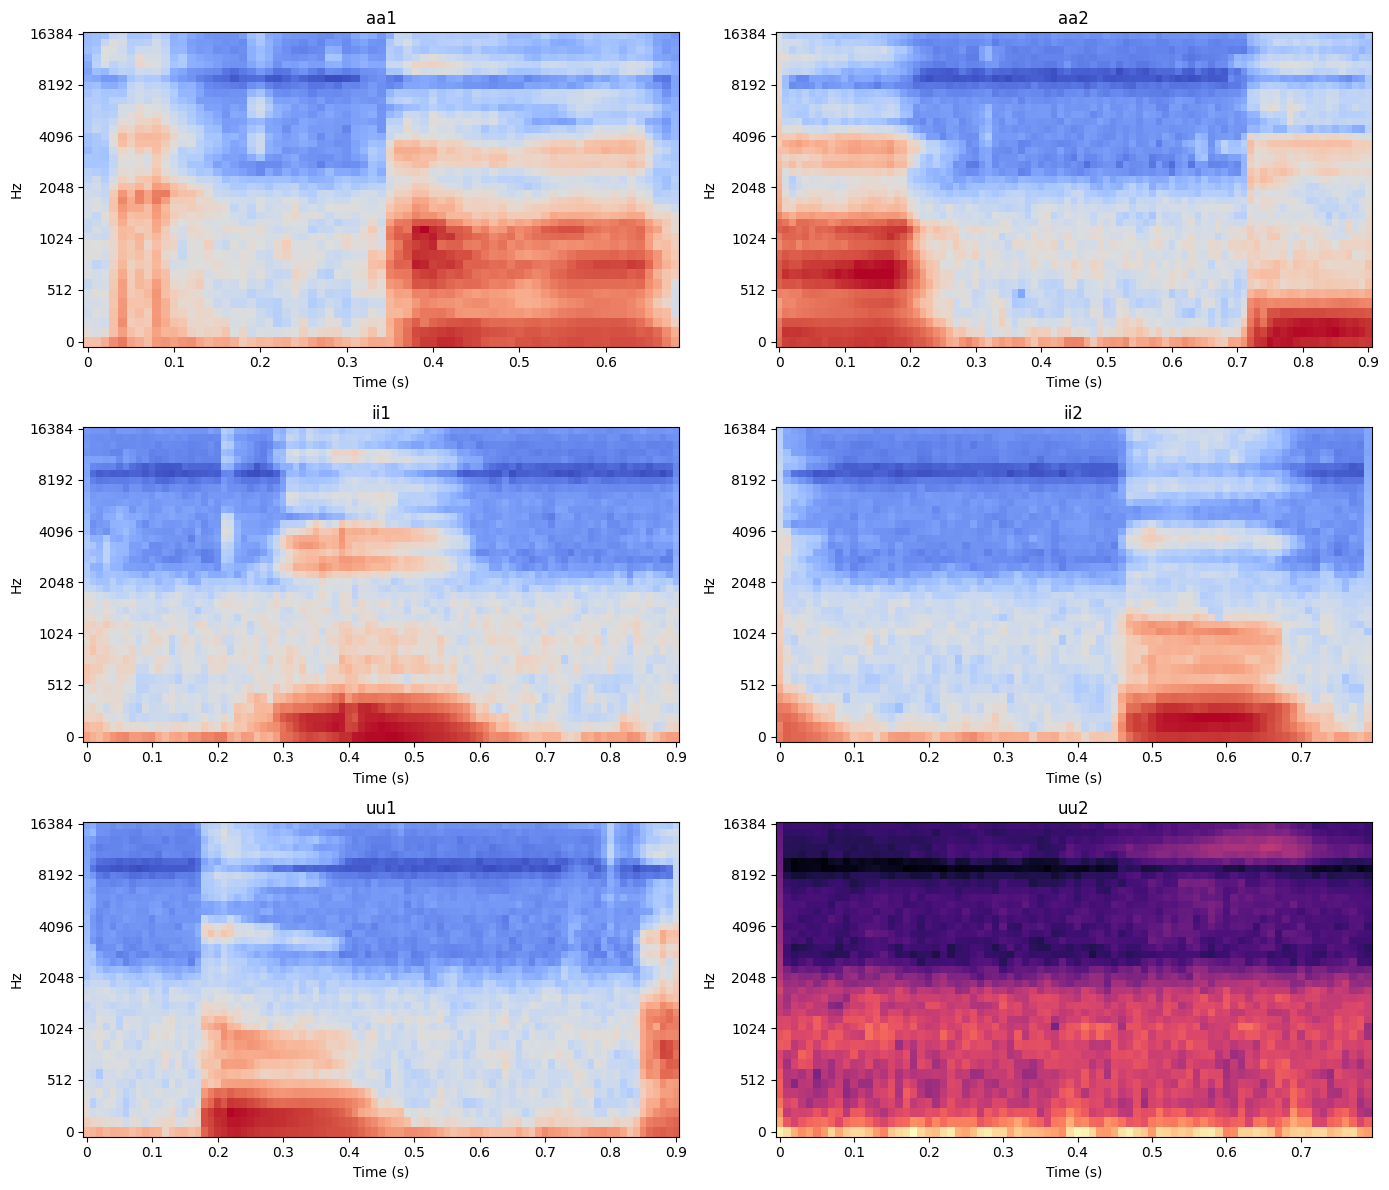

In [27]:
titles = [['aa1','aa2'],['ii1','ii2'],['uu1','uu2']]

fig = plt.figure(figsize=(14,12))
axes = fig.subplots(3,2)
for row in [0,1,2]:
    for column in [0,1]:
        librosa.display.specshow(
            melgrams[row][column],
            sr=speech_rate,
            hop_length=hop,
            y_axis='mel',
            x_axis='s',
            fmax=16000,
            ax=axes[row][column]                     
        )
        axes[row][column].set_title(titles[row][column])
        
fig.tight_layout()

Notice that:
* The two `aa` vowels look very similar
* The two `ii` vowels look very similar
* The two `uu` vowels look very similar


<a id='section_melspectrum'></a>

## 3. Calculate the average mel-frequency spectrum

The melspectrogram has less information than the spectrogram, but it **still** has too much information for do-it-yourself speech recognition.  

In order to make the task easier to work with, we will average, over time, in order to calculate a **mel spectrum** -- the average of the melspectrogram.

In [28]:
melspectra = [[None,None],[None,None],[None,None]]
for row in [0,1,2]:
    for column in [0,1]:
        melspectra[row][column]=np.average(
            melgrams[row][column],
            axis=1
        )

In order to make the similarities and differences easier to see, let's plot them all on the same axes:

Text(0.5, 1.0, 'Mel spectra of all six vowels')

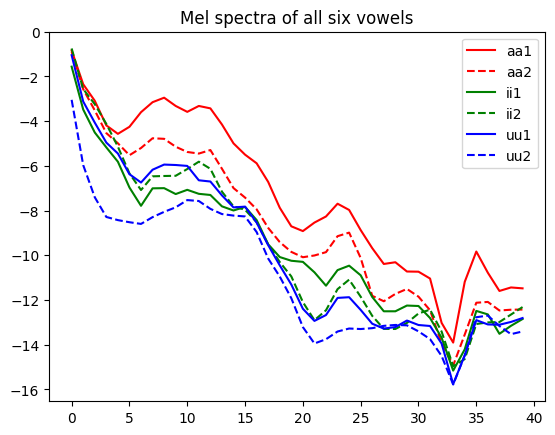

In [29]:
plt.plot(melspectra[0][0],'r-')
plt.plot(melspectra[0][1],'r--')
plt.plot(melspectra[1][0],'g-')
plt.plot(melspectra[1][1],'g--')
plt.plot(melspectra[2][0],'b-')
plt.plot(melspectra[2][1],'b--')
plt.legend(['aa1','aa2','ii1','ii2','uu1','uu2'])
plt.title('Mel spectra of all six vowels')

Notice that:
* `aa1` is similar to `aa2`
* `ii1` is similar to `ii2`
* `uu1` is similar to `uu2`

We can make them even more similar by calculating the **zero-mean mel spectra** (ZMMS), as shown here:

In [30]:
zmms = [[None,None],[None,None],[None,None]]
for row in [0,1,2]:
    for column in [0,1]:
        average = np.average(melspectra[row][column])
        zmms[row][column]=melspectra[row][column] - average

[[array([ -0.8363501 ,  -2.34933378,  -3.08891672,  -4.18990769,
        -4.56788378,  -4.25272725,  -3.59925389,  -3.15232721,
        -2.95147753,  -3.32092123,  -3.58453763,  -3.32088711,
        -3.42870707,  -4.14957142,  -4.99410637,  -5.49885342,
        -5.88454365,  -6.71795128,  -7.87312941,  -8.70313377,
        -8.91649727,  -8.53613037,  -8.26304955,  -7.69243501,
        -7.97145561,  -8.87199094,  -9.68075976, -10.38686192,
       -10.31001261, -10.72426357, -10.73251172, -11.03893679,
       -13.02174898, -13.90286747, -11.18514651,  -9.83074378,
       -10.78077887, -11.59359909, -11.43740691, -11.4772051 ]), array([ -0.88934921,  -2.56930523,  -3.51971403,  -4.53510794,
        -4.98977414,  -5.52374419,  -5.20128904,  -4.76579985,
        -4.79066017,  -5.14432523,  -5.37869158,  -5.45000984,
        -5.29240846,  -6.1283548 ,  -6.99336019,  -7.41839176,
        -7.94330616,  -8.77434993,  -9.40865862,  -9.8472312 ,
       -10.08542927, -10.00739135,  -9.8585915 ,  -

Text(0.5, 1.0, 'Zero-mean Mel spectra of all six vowels')

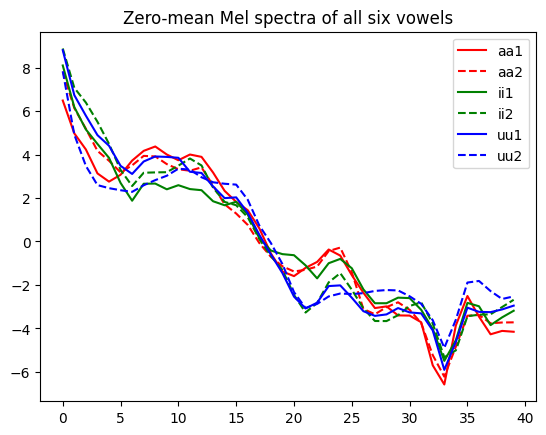

In [31]:
plt.plot(zmms[0][0],'r-')
plt.plot(zmms[0][1],'r--')
plt.plot(zmms[1][0],'g-')
plt.plot(zmms[1][1],'g--')
plt.plot(zmms[2][0],'b-')
plt.plot(zmms[2][1],'b--')
plt.legend(['aa1','aa2','ii1','ii2','uu1','uu2'])
plt.title('Zero-mean Mel spectra of all six vowels')

<a id='section_recognition'></a>

## 4. Recognize a vowel by finding its nearest neighbor

Automatic speech recognition needs two inputs:

* A **test speech waveform** that you want to recognize
* A set of **models** that describe the different possible **texts**.

In this lab, we will create **test speech** and **models** as follows:

* The waveforms `aa2.wav`, `ii2.wav`, and `uu2.wav` will be **test speech**.  We will pretend that we don't know what each waveform says.
* The waveforms `aa1.wav`, `ii1.wav`, and `uu1.wav` will be **models**. 

In the following block of code, choose one of the test speeches, and compare it to each of the three models, to see which one is closest.

In [32]:
# choose one of the "test speech waveforms"
test_speech = zmms[1][1]

# Choose the three models, and say what their labels are
models = [zmms[0][0], zmms[1][0], zmms[2][0]]
labels = ['aa', 'ii', 'uu']

# The three distances are all zero until we compute them
distances = [0,0,0]

# Compute the distances
for i in range(3):
    distances[i] = np.linalg.norm(test_speech - models[i])
print("The three distances are:\n",distances)

# Find out which one was best
best_label = labels[np.argmin(distances)]
print("The vowel was recognized as",best_label)


The three distances are:
 [7.4352475446263, 5.249401972197731, 2.3245406339013654]
The vowel was recognized as uu


<a id="homework"></a>

## Homework for Week 6

Homework will be autograded on Gradescope.  

Submit a file called `homework6.py`.

It should be a copy of the following file, but everywhere that you see the comment `# CHANGE THIS!`, you should change that line in order to implement the specified function.


In [33]:
import numpy as np
import librosa
import librosa.feature

'''
homework6.py

Copy this text to a new text file, and then edit it
so that the functions below perform the tasks specified.
'''

def waveform_to_cstft(speech_wave, hop, win):
    '''
    Given a speech_wave, this function should return a CSTFT
    (a complex-valued short-time Fourier transform)
    with the specified hop_length and win_length.
    '''
    cstft = np.zeros(2,2)   # CHANGE THIS!
    return cstft
    
def cstft_to_mstft(cstft):
    '''
    Given a CSTFT, this function should return an MSTFT
    (a magnitude short-time Fourier transform).
    '''
    mstft = np.zeros(2,2) # CHANGE THIS!
    return mstft

def mstft_to_sgram(mstft):
    '''
    Given an MSTFT (a magnitude short-time Fourier transform), 
    this function should return a spectrogram.
    '''
    sgram = np.zeros(2,2) # CHANGE THIS!
    return sgram

def waveform_to_mmgram(speech_wave,speech_rate,hop,win):
    '''
    Given a speech_wave, this function should return an MMGRAM
    (a magnitude mel-spectrogram)
    with the specified speech_rate, hop_length, and win_length,
    and with n_mels=40, and fmax=16000.
    '''
    mmgram = np.zeros(2,2)   # CHANGE THIS!
    return mmgram

def mmgram_to_melgram(mmgram):
    '''
    Given an MMGRAM (a magnitude mel-spectrogram),
    this function should return a mel-spectrogram.
    '''
    melgram = np.zeros(2,2)   # CHANGE THIS!
    return melgram

def melgram_to_melspectrum(melgram):
    '''
    Given a mel-spectrogram, return a mel-spectrum.
    '''
    melspectrum = np.zeros(2)   # CHANGE THIS!
    return melspectrum

def melspectrum_to_zmms(melspectrum):
    '''
    Given a mel-spectrum, return a ZMMS
    (a zero-mean mel-spectrum).
    '''
    zmms = np.zeros(2)   # CHANGE THIS!
    return zmms

def recognize_speech(test_speech, models, labels):
    '''
    Given a test_speech, a list of 3 models, and a list of 3 labels,
    return a list of three distances, and the best label.
    '''
    distances = np.zeros(2)  # CHANGE THIS!
    best_label = "lalala"    # CHANGE THIS!
    return distances, best_label